In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
from PIL import Image
from io import BytesIO
from six.moves import urllib
from tensorflow.keras.applications import inception_v3, InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions
from skimage.transform import resize, rescale

tf.__version__

'1.9.0'

# Lab: occlusion for interpretability

In this lab you will need to:

1. Load an image
2. Load InceptionV3
3. Obtain InceptionV3 prediction
4. Run a 50x50 occlusion window across the image with an overlapping stride of 5 pixels
5. For each position of the occlusion window record the model probability the prediction obtained in step 3
6. Create a heatmap with the recorded probabilities and scale it to the size of the original image
7. Plot the heatmap alongside the original image. You may also plot the heatmap over the image with some alpha


Use the following two images

For the french horn the resulting heatmap, before rescaling should have a size of 19x21 and the oboe 21x31.

The InceptionV3 with imagenet prediction class code fore the french horn should be 566 and for the oboe 683

The following are possible results

![](Images/lab_french-horn-occlusion.png)

![](Images/lab_oboe-occlusion.png)

### 1. Load an image

(-0.5, 199.5, 149.5, -0.5)

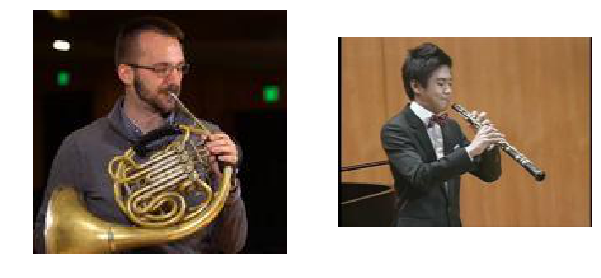

In [6]:
french = plt.imread("Images/french-horn.jpg")
oboe = plt.imread("Images/oboe.jpg")
plt.figure(figsize=(10,6))
plt.subplot(121); plt.imshow(french); plt.axis("off")
plt.subplot(122); plt.imshow(oboe); plt.axis("off")

In [7]:
print np.min(french), np.max(french), french.shape
print np.min(oboe), np.max(oboe), oboe.shape

0 255 (144, 150, 3)
0 255 (150, 200, 3)


### 2. Load InceptionV3

In [8]:
model = InceptionV3(weights='imagenet', include_top=True)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

### 3. Obtain InceptionV3 prediction

In [10]:
#Prediction for french horn
fimg = inception_v3.preprocess_input(np.expand_dims(french.astype(float), axis=0))
fpred = model.predict(fimg)


In [122]:
class_code = 566
decode_pred = decode_predictions(fpred, top=3)
fproba_pred = fpred[0][class_code]
print "class_code", class_code
print "proability", fpred[0][class_code]
print 'predicted:', decode_pred



class_code 566
proability 1.0
predicted: [[(u'n03394916', u'French_horn', 1.0), (u'n02804610', u'bassoon', 4.2835346e-19), (u'n03838899', u'oboe', 6.7436453e-21)]]


In [123]:
#Prediction for oboe
oimg = inception_v3.preprocess_input(np.expand_dims(oboe.astype(float), axis=0))
opred = model.predict(oimg)
class_code = 683
oproba_pred = opred[0][class_code]
print "class_code", class_code
print "proability", oproba_pred
print 'predicted:', decode_predictions(opred, top=3)

class_code 683
proability 0.9999999
predicted: [[(u'n03838899', u'oboe', 0.9999999), (u'n03372029', u'flute', 7.642359e-08), (u'n03110669', u'cornet', 3.0982266e-09)]]


### 4. Run a occlusion window

Run a 50x50 occlusion window across the image with an overlapping stride of 5 pixels

In [141]:
def run_occlusion(img, class_code,step=5, win=50):
    img_copy = img.copy()
    h = img.shape[0]
    w = img.shape[1]
   
    h_new = (h - win)/step + 1
    w_new = (w - win)/step + 1
    
    img_new = np.ones((h_new, w_new))

    for i in range(0,h-win,5):
        for j in range(0,w-win ,5):
            img_copy = img.copy()
            img_copy[i:i+win,j:j+win] = 255
         
            img_copy = inception_v3.preprocess_input(np.expand_dims(img_copy.astype(float), axis=0))
            pred = model.predict(img_copy)
            pred_new = pred[0][class_code]
            # 5. Record the model probability the prediction
            img_new[i/step,j/step] = pred_new
        
    return img_new
           
       

### 6. Create a heatmap 
Create a heatmap with the recorded probabilities and scale it to the size of the original image.
For the french horn the resulting heatmap, before rescaling should have a size of 19x21 and the oboe 21x31.

In [142]:
#Oboe
oboe_new = run_occlusion(oboe,683)


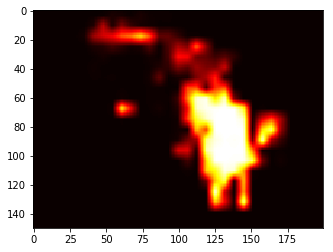

In [223]:
oboe_invert = np.max(oboe_new) - oboe_new
oboe_invert = resize(oboe_invert, (150,200))

plt.imshow(oboe_invert, cmap='hot')

In [162]:
#French horn
french_new = run_occlusion(french,566)


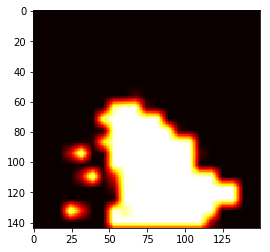

In [207]:
f_invert = np.max(french_new) - french_new
f_invert =  resize(f_invert, (144,150))
plt.imshow(f_invert, cmap='hot')


### 7. Plot the heatmap alongside the original image. 

Plot the heatmap alongside the original image. You may also plot the heatmap over the image with some alpha

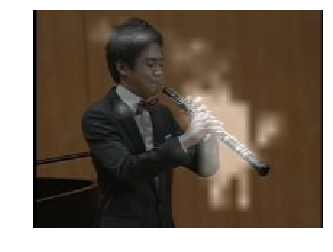

In [225]:

plt.imshow(oboe, interpolation='none')
plt.imshow(oboe_invert, cmap = 'gray', interpolation='none', alpha=0.5)
plt.axis('off')


plt.show()

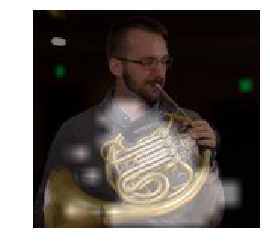

In [210]:
plt.imshow(french, interpolation='none')
plt.imshow(f_invert, cmap = 'gray', interpolation='none', alpha=0.5)
plt.axis('off')


plt.show()


## Results

(-0.5, 199.5, 149.5, -0.5)

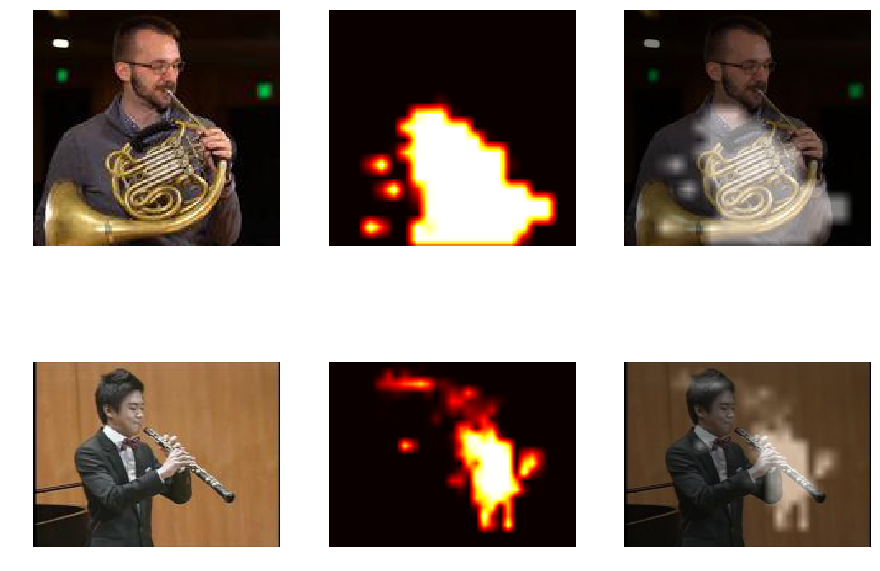

In [226]:
plt.figure(figsize=(15,11))
plt.subplot(231); plt.imshow(french); plt.axis("off")
plt.subplot(232); plt.imshow(f_invert,cmap='hot'); plt.axis("off")

plt.subplot(233); 
plt.imshow(french, interpolation='none')
plt.imshow(f_invert, cmap = 'gray', interpolation='none', alpha=0.5)
plt.axis("off")

plt.subplot(234); plt.imshow(oboe); plt.axis("off")
plt.subplot(235); plt.imshow(oboe_invert,cmap='hot'); plt.axis("off")

plt.subplot(236); 
plt.imshow(oboe, interpolation='none')
plt.imshow(oboe_invert, cmap = 'gray', interpolation='none', alpha=0.5)
plt.axis("off")